In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

import sys

thismodule = sys.modules[__name__]

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

## SM

In [7]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

wgamma_cross = 0.944 * 1000 #[fb]
wgamma_NLO   = 2.37 # k-factor [14 TeV]

wjets_cross = 168.12 * 1000 #[fb]
wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [8]:
wgamma_fidcross  = 110.02191836496351
wjets_fidcross   = 108.33785910195228
ttgamma_fidcross = 5.23820

ttjets_fidcross  = 22.388
zjets_fidcross   = 3.5025615
wz_fidcross      = 2.2074
zz_fidcross      = 0.2848
ww_fidcross      = 4.197
tj_fidcross      = 0.9348
tb_fidcross      = 1.293
tw_fidcross      = 2.1975

bkg = ['wgamma', 'wjets', 'ttgamma',
       'zjets',
       'ttjets',
       'tj', 'tb', 'tw',
       'ww', 'zz', 'wz'
      ]

B_fidcross_tot = 0
for i, ibkg in enumerate(bkg):
    B_fidcross_tot = B_fidcross_tot + globals()[ibkg + '_fidcross']
B_fidcross_tot

260.6030389669158

In [9]:
wgamma_aceptancia_init  = wgamma_fidcross / (wgamma_cross * wgamma_NLO)
wjets_aceptancia_init   = wjets_fidcross / (wjets_cross * wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [10]:
wgamma_expected  = 11002.191836496351
wjets_expected   = 10833.785910195227
ttgamma_expected = 523.820

ttjets_expected  = 2238.5992598
zjets_expected   = 350.25615
wz_expected      = 220.74
zz_expected      = 28.481
ww_expected      = 419.71
tj_expected      = 93.489
tb_expected      = 129.372
tw_expected      = 219.75

B_expected = 0
for i, ibkg in enumerate(bkg):
    B_expected = B_expected + globals()[ibkg + '_expected']
B_expected

26060.19515649158

In [11]:
sample = 60_000 # Number of signal and background events to train and validate

wgamma_sample  = int(round(sample * wgamma_fidcross / B_fidcross_tot))
wjets_sample   = int(round(sample * wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(wgamma_sample)
print(wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

25331
24943
1206
5155
806
508
66
966
215
298
506


In [12]:
datFolderwgamma  = '../data/Wgamma/'
datFolderwjets   = '../data/Wjets/'
datFolderttgamma = '../data/ttGamma/'
datFolderttjets  = '../data/ttjets/'
datFolderzjets   = '../data/Zlep+j/'
datFolderwz      = '../data/wz/'
datFolderww      = '../data/ww/'
datFolderzz      = '../data/zz/'
datFoldertj      = '../data/singleTop+j/'
datFoldertb      = '../data/singleTop+b/'
datFoldertw      = '../data/singleTop+W/'

for i, ibkg in enumerate(bkg):
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'photon_6.dat', delimiter=' ')
    setattr(thismodule, 'photon_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'jet_6.dat', delimiter=' ')
    setattr(thismodule, 'jet_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'lepton_6.dat', delimiter=' ')
    setattr(thismodule, 'lepton_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'MET_6.dat', delimiter=' ')
    setattr(thismodule, 'MET_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'hadinfo_6.dat', delimiter=' ')
    setattr(thismodule, 'hadinfo_' + ibkg, aux)

In [13]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM  = globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]
        jet_SM     = globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]
        lepton_SM  = globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]
        MET_SM     = globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]
        hadinfo_SM = globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]
    else:
        photon_SM  = np.concatenate([photon_SM, globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]])
        jet_SM     = np.concatenate([jet_SM, globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]])
        lepton_SM  = np.concatenate([lepton_SM, globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]])
        MET_SM     = np.concatenate([MET_SM, globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]])
        hadinfo_SM = np.concatenate([hadinfo_SM, globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]])

In [14]:
bkg_flag = np.zeros(len(photon_SM))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag[:globals()[ibkg + '_sample']] = i + 1
        end_ind = globals()[ibkg + '_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_sample']
        bkg_flag[(init_ind):(end_ind)] = i + 1

In [15]:
wjets_pool  = len(photon_wjets[wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / wjets_fidcross)

wgamma_pool_sample  = int(round(pool_sample * wgamma_fidcross / B_fidcross_tot))
wjets_pool_sample   = int(round(pool_sample * wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(wgamma_pool_sample)
print(wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

22179
21840
1056
4513
706
445
57
846
188
261
506


In [16]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM_pool  = globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        jet_SM_pool     = globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        lepton_SM_pool  = globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        MET_SM_pool     = globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        hadinfo_SM_pool = globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
    else:
        photon_SM_pool  = np.concatenate([photon_SM_pool, globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        jet_SM_pool     = np.concatenate([jet_SM_pool, globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        lepton_SM_pool  = np.concatenate([lepton_SM_pool, globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        MET_SM_pool     = np.concatenate([MET_SM_pool, globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        hadinfo_SM_pool = np.concatenate([hadinfo_SM_pool, globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])

In [17]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag_pool[:globals()[ibkg + '_pool_sample']] = i + 1
        end_ind = globals()[ibkg + '_pool_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_pool_sample']
        bkg_flag_pool[(init_ind):(end_ind)] = i + 1

In [18]:
print(photon_wjets.shape)
print(photon_ttgamma.shape)
print(photon_wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(46783, 4)
(568366, 4)
(673720, 4)
(11533, 4)
(1576, 4)
(3028, 4)
(844, 4)
(7330, 4)
(568, 4)
(670, 4)
(3050, 4)


### Other variables

In [19]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [20]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## NP

In [21]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_6.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_6.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_6.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_6.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_6.dat', delimiter=' ') )

In [22]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (60000, 5)
BP1 (210768, 5)
BP2 (220621, 5)
BP3 (224270, 5)
BP4 (268160, 5)
BP5 (254511, 5)
BP6 (218307, 5)
BP7 (302978, 5)
BP8 (279921, 5)
BP9 (244546, 5)
BP10 (330992, 5)
BP11 (302374, 5)
BP12 (268335, 5)
BP13 (356324, 5)
BP14 (324324, 5)
BP15 (288862, 5)


In [23]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([210768, 220621, 224270, 268160, 254511, 218307, 302978, 279921, 244546, 330992, 302374, 268335, 356324, 324324, 288862])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.02450796 4.59030589 6.36297195 1.11064713 2.35495829 3.33821603
 0.66005614 1.29200298 1.79306845 0.39933235 0.73575485 1.01992452
 0.22901644 0.41142086 0.57265147]
Events expected:  [202.4507965  459.03058905 636.29719543 111.06471288 235.49582866
 333.82160293  66.00561444 129.20029848 179.30684468  39.93323524
  73.57548516 101.99245228  22.90164413  41.14208595  57.26514737]


In [24]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [25]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(60000, 4)
(210768, 4)


# Analysis

## training

In [26]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(60000, 4)
(60000, 3)
(60000, 5)
(60000, 3)
(60000, 3)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)


In [27]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 2

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(224270, 4)
(224270, 3)
(224270, 5)
(224270, 3)
(224270, 3)
(224270,)
(224270,)
(224270,)
(224270,)
(224270,)
(224270,)


In [28]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

60000

In [29]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,167.35,0.090,1.129,1.0,655.44,0.148,-0.773,139.93,-1.137,-3.088,...,1314.96,1007.68,3.0,962.72,6.781133,319.065256,770.491669,47.391518,2.0,0.0
1,27.73,-1.097,0.395,1.0,317.64,-0.654,2.866,35.07,-0.504,0.563,...,433.90,371.10,2.0,380.44,11.559622,55.501146,553.082039,76.699361,1.0,0.0
2,31.06,-1.243,-0.958,1.0,343.00,-1.311,1.849,56.61,-1.949,-1.365,...,430.67,343.00,1.0,430.67,11.470857,37.781698,570.653978,4.178878,1.0,0.0
3,40.08,0.829,-0.111,1.0,205.80,0.087,2.647,27.43,1.445,-0.083,...,412.18,344.67,3.0,273.31,10.521019,24.997927,418.663155,22.801622,1.0,0.0
4,49.94,-1.080,1.212,1.0,374.24,-0.635,-0.046,130.06,-1.286,2.786,...,600.26,420.26,2.0,554.24,11.158274,193.567717,639.341654,70.887343,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,17.24,-1.628,-1.853,1.0,267.12,-0.573,-1.771,27.90,0.227,1.345,...,389.84,344.70,3.0,312.26,15.127860,142.608325,563.476927,15.409275,0.0,1.0
119996,17.19,-0.827,-1.246,1.0,291.73,-0.917,3.108,12.69,0.014,-1.183,...,796.47,649.95,4.0,321.61,16.638202,37.632979,683.170783,27.563611,0.0,1.0
119997,17.06,0.448,-1.927,1.0,243.31,-0.318,1.547,14.29,0.486,0.227,...,367.10,335.75,4.0,274.66,14.043427,25.258394,511.616006,96.330518,0.0,1.0
119998,14.06,-1.495,1.176,1.0,310.60,-0.178,-1.236,11.94,-0.174,2.061,...,386.23,360.23,2.0,336.60,11.872139,38.525066,538.274164,10.486109,0.0,1.0


In [30]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,103.07,0.462,0.805,1.0,409.84,-1.700,-2.472,34.27,0.020,1.647,...,728.08,590.74,4.0,547.18,9.851033,18.363345,660.070744,87.553762,1.0,0.0
1,45.55,-1.856,0.766,1.0,216.66,-0.236,1.484,53.88,-2.290,-1.529,...,398.84,299.41,4.0,316.09,10.480708,191.322428,420.654700,46.661150,2.0,0.0
2,13.09,-0.931,2.129,1.0,416.79,0.171,-1.238,198.39,-1.287,2.041,...,1140.93,929.45,5.0,628.27,10.633657,28.587647,770.168624,88.218088,2.0,0.0
3,10.60,0.830,1.477,1.0,197.45,1.320,-2.008,187.70,0.842,1.473,...,684.63,486.33,5.0,395.75,7.741511,42.507139,381.541641,178.178044,11.0,0.0
4,43.05,1.570,-2.434,1.0,324.25,0.708,0.596,53.32,0.872,-1.599,...,611.09,514.72,2.0,420.62,12.782241,39.808836,623.710739,63.219464,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216799,25.79,-0.986,-0.423,1.0,602.06,-0.538,3.100,16.68,-1.554,0.229,...,672.12,629.65,2.0,644.53,20.545971,45.421292,1132.585291,24.625298,0.0,1.0
216800,41.69,-0.507,0.050,1.0,355.37,-1.092,-2.661,11.34,0.146,2.684,...,408.40,355.37,1.0,408.40,14.403549,45.173239,643.220323,102.946687,0.0,1.0
216801,63.90,0.135,1.937,1.0,356.03,-0.655,-1.334,16.48,0.376,-0.977,...,722.80,642.42,3.0,436.41,19.153474,55.470271,852.976748,177.698589,0.0,1.0
216802,19.17,-0.129,-2.039,1.0,320.03,-1.080,0.244,17.71,-1.169,2.386,...,417.98,381.10,2.0,356.91,16.096214,76.296917,647.379113,63.384164,0.0,1.0


In [31]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [32]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [33]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [34]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [35]:
for i, ibkg in enumerate(bkg):
    ind_train = np.where(bkg_flag_train == (i + 1))[0]
    if(len(ind_train) < globals()[ibkg + '_expected']): 
        print('In training there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_train), globals()[ibkg + '_expected']))
        
    ind_test = np.where(bkg_flag_test == (i + 1))[0]
    if(len(ind_test) < globals()[ibkg + '_expected']): 
        print('In testing there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_test), globals()[ibkg + '_expected']))
        
    ind_val = np.where(bkg_flag_val == (i + 1))[0]
    if(len(ind_val) < globals()[ibkg + '_expected']): 
        print('In val there are less ' + ibkg + ' events {} than expected {}'.format(len(ind_val), globals()[ibkg + '_expected']))

In val there are less wgamma events 5075 than expected 11002.191836496351
In val there are less wjets events 4992 than expected 10833.785910195227
In val there are less ttgamma events 254 than expected 523.82
In val there are less zjets events 177 than expected 350.25615
In val there are less ttjets events 992 than expected 2238.5992598
In val there are less tj events 34 than expected 93.489
In val there are less tb events 50 than expected 129.372
In val there are less tw events 134 than expected 219.75
In val there are less ww events 188 than expected 419.71
In val there are less zz events 10 than expected 28.481
In val there are less wz events 79 than expected 220.74


In [36]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [37]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.63178	validation_1-logloss:0.63195
[1]	validation_0-logloss:0.58109	validation_1-logloss:0.58137
[2]	validation_0-logloss:0.53908	validation_1-logloss:0.53947
[3]	validation_0-logloss:0.50326	validation_1-logloss:0.50365
[4]	validation_0-logloss:0.47146	validation_1-logloss:0.47203
[5]	validation_0-logloss:0.44530	validation_1-logloss:0.44624
[6]	validation_0-logloss:0.42185	validation_1-logloss:0.42300
[7]	validation_0-logloss:0.40106	validation_1-logloss:0.40232
[8]	validation_0-logloss:0.38343	validation_1-logloss:0.38477
[9]	validation_0-logloss:0.36768	validation_1-logloss:0.36938
[10]	validation_0-logloss:0.35339	validation_1-logloss:0.35540
[11]	validation_0-logloss:0.34047	validation_1-logloss:0.34263
[12]	validation_0-logloss:0.32931	validation_1-logloss:0.33162
[13]	validation_0-logloss:0.31829	validation_1-logloss:0.32083
[14]	validation_0-logloss:0.30920	validation_1-logloss:0.31176
[15]	validation_0-logloss:0.30095	validation_1-logloss:0.30362
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [38]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [39]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (96000, 22)
y_mon_train :  (96000,)
X_mon_val :  (24000, 22)
y_mon_val :  (24000,)
X_mon_test :  (216804, 22)
y_mon_test :  (216804,)



In [40]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total = np.zeros(nvals) 
fpr_total = np.zeros(nvals) 
tpr_bkg   = np.zeros((len(bkg), nvals))
fpr_bkg   = np.zeros((len(bkg), nvals))

for ith, th in tqdm(enumerate(np.linspace(0,1, nvals))):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))

    for i, ibkg in enumerate(bkg):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == (i + 1)) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]
    
        tpr_bkg[i, ith] = len(tp) / (len(tp) + len(fn))
        fpr_bkg[i, ith] = len(fp) / (len(fp) + len(tn))

50it [00:00, 116.92it/s]


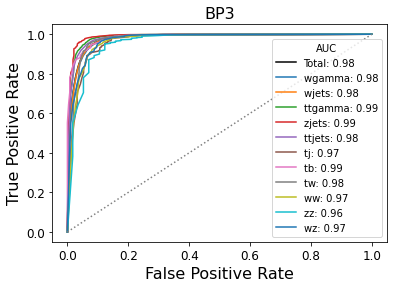

In [41]:
plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total: {:.2f}'.format(auc(fpr_total, tpr_total)))

for i, ibkg in enumerate(bkg):
    plt.plot(fpr_bkg[i,:], tpr_bkg[i,:], label = ibkg + ': {:.2f}'.format(auc(fpr_bkg[i,:], tpr_bkg[i,:])))
plt.legend(title = 'AUC')

plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)
plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_MET200.png', bbox_inches='tight')

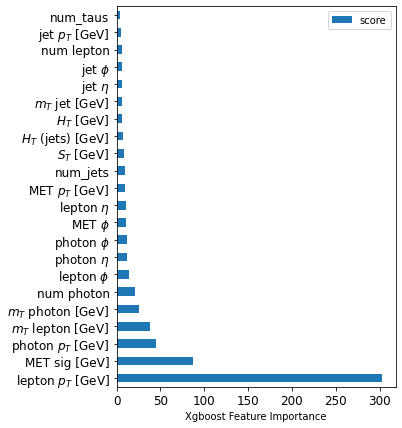

In [42]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/ImpVars_BP' + str(bp + 1) + '_ALL_MET200.png', bbox_inches='tight')

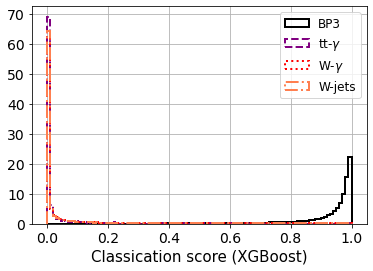

In [43]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_ALL_MET200.png', bbox_inches="tight")

In [44]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [45]:
len(np.where(bkg_flag_test != 0)[0])

52534

In [46]:
len(np.where(bkg_flag_test == 0)[0])

164270

Text(0.5, 1.0, 'BP3')

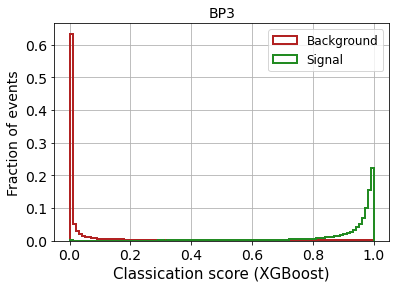

In [47]:
# XGBoost

########################
# CLASSIFICATION SCORE #
########################
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('BP' + str(bp + 1), fontsize=14)

#plt.savefig('../graph/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")

In [48]:
S_expected[bp]

636.2971954330917

In [49]:
S_expected[bp] / np.sqrt(B_expected)

3.941587547204874

In [50]:
B_expected

26060.19515649158

In [51]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_1921569/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [139]:
nbins = 10
indices_aux = np.arange(len(df_test_array))
        
n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))
#random_vars = list(np.argsort(values)[::-1])*10

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])

        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])

        wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

lepton $p_T$ [GeV] <= 202.01666666666668; Z = 0.2709365663767802
$H_T$ (jets) [GeV] <= 1597.1433333333332; Z = 0.27129308275460573
lepton $\phi$ <= 3.142; Z = 0.27129308275460573
$S_T$ [GeV] <= 1242.39; Z = 0.27144588680696613
jet $p_T$ [GeV] <= 1088.8011111111111; Z = 0.27144980819932035
photon $p_T$ [GeV] <= 106.98666666666666; Z = 0.28267843486560607
jet $\phi$ <= 3.142; Z = 0.28267843486560607
MET $\phi$ <= 3.142; Z = 0.28267843486560607
photon $\eta$ <= 1.8425555555555557; Z = 0.28288569431148736
jet $\eta$ >= -3.455666666666667; Z = 0.28309963928473564
$m_T$ jet [GeV] >= 568.5187872104101; Z = 0.30209592969573973
$H_T$ [GeV] <= 1438.21; Z = 0.30536276185118816
lepton $\eta$ <= 2.499; Z = 0.30536276185118816
photon $\phi$ <= 3.142; Z = 0.30536276185118816
num_jets <= 6.555555555555555; Z = 0.3076337385837507
$m_T$ photon [GeV] >= 64.27491051657147; Z = 0.3092439020338249
num_taus <= 1.1111111111111112; Z = 0.3092895504024203
MET sig [GeV] >= 18.206194425344457; Z = 0.5073336099414

In [128]:
sup_cuts

{'$m_T$ jet [GeV]': np.float64(1757.495074088683),
 'num_jets': np.float64(7.0),
 'lepton $p_T$ [GeV]': np.float64(26.27),
 '$S_T$ [GeV]': np.float64(935.42),
 'jet $p_T$ [GeV]': np.float64(908.95),
 'photon $\\eta$': np.float64(1.842),
 '$m_T$ photon [GeV]': np.float64(208.03561867838778),
 'num lepton': np.float64(1.0),
 'num photon': np.float64(1.0),
 'photon $\\phi$': np.float64(3.142),
 'num_taus': np.float64(1.0),
 'photon $p_T$ [GeV]': np.float64(69.22),
 'lepton $\\eta$': np.float64(1.511),
 'lepton $\\phi$': np.float64(3.141),
 'MET $\\phi$': np.float64(3.142),
 '$H_T$ [GeV]': np.float64(1247.3822222222223),
 '$H_T$ (jets) [GeV]': np.float64(1326.25),
 'jet $\\eta$': np.float64(3.386),
 'MET sig [GeV]': np.float64(29.645158479081314),
 'jet $\\phi$': np.float64(3.141),
 'MET $p_T$ [GeV]': np.float64(870.83),
 '$m_T$ lepton [GeV]': np.float64(197.42942783126662)}

In [129]:
inf_cuts

{'$m_T$ jet [GeV]': np.float64(423.5948929114181),
 'num_jets': -999999,
 'lepton $p_T$ [GeV]': -999999,
 '$S_T$ [GeV]': -999999,
 'jet $p_T$ [GeV]': -999999,
 'photon $\\eta$': -999999,
 '$m_T$ photon [GeV]': np.float64(46.23013748408617),
 'num lepton': -999999,
 'num photon': -999999,
 'photon $\\phi$': -999999,
 'num_taus': -999999,
 'photon $p_T$ [GeV]': -999999,
 'lepton $\\eta$': np.float64(-1.9444444444444444),
 'lepton $\\phi$': -999999,
 'MET $\\phi$': -999999,
 '$H_T$ [GeV]': np.float64(298.67111111111114),
 '$H_T$ (jets) [GeV]': -999999,
 'jet $\\eta$': np.float64(-2.2248888888888887),
 'MET sig [GeV]': np.float64(15.808304044471795),
 'jet $\\phi$': -999999,
 'MET $p_T$ [GeV]': -999999,
 '$m_T$ lepton [GeV]': -999999}

In [130]:
write = True
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_ALL.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_ALL.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_ALL.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_ALL.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [131]:
SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

SM_indices = np.random.choice(SM_test_pool, size = int(B_expected), replace = False)
NP_indices = np.random.choice(NP_test_pool, size = int(S_expected[bp]), replace = False)
indices_aux = np.concatenate((NP_indices, SM_indices))

n_np0  = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

#indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [132]:
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = wgamma_cross * wgamma_NLO * luminosidad * (n_wgamma * wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = wjets_cross * wjets_NLO * luminosidad * (n_wjets * wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = n_np#int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wjets_expected + wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  0.6088516355313051
Expected Background = 170
Expected Signal = 8


In [133]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])
    
    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
    n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
    n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
    n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
    n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
    n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
    n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
    n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
    n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                           n_ttjets + n_zjets + n_wz + \
                           n_zz + n_ww + n_tj + \
                           n_tb + n_tw
        
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                 n_ttjets + n_zjets + n_wz + \
                 n_zz + n_ww + n_tj + \
                 n_tb + n_tw
    
    if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 103.23it/s]


(array([ 29., 121., 341., 439., 461., 310., 189.,  78.,  23.,   9.]),
 array([ 2. ,  4.1,  6.2,  8.3, 10.4, 12.5, 14.6, 16.7, 18.8, 20.9, 23. ]),
 <BarContainer object of 10 artists>)

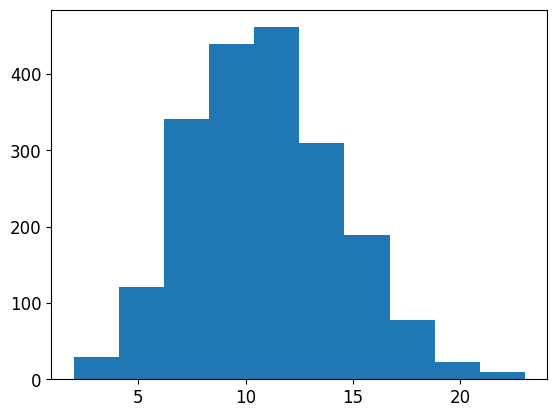

In [134]:
plt.hist(S_observed_exp)

(array([ 15.,  48., 198., 345., 514., 457., 245., 125.,  44.,   9.]),
 array([128. , 134.7, 141.4, 148.1, 154.8, 161.5, 168.2, 174.9, 181.6,
        188.3, 195. ]),
 <BarContainer object of 10 artists>)

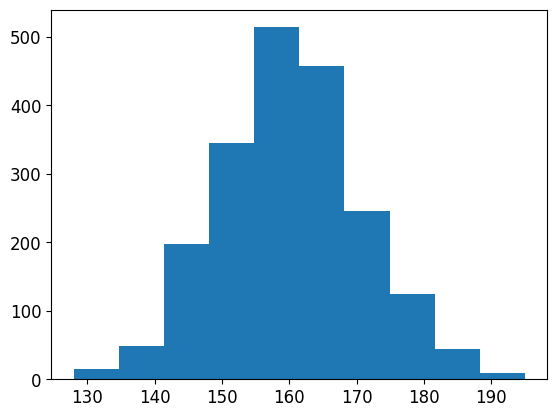

In [135]:
plt.hist(B_observed_exp)

In [136]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 12
 
Z = 0.5406246245031705; Z_std = 0.93773636582145
B_exp = 160.1445; B_exp_std = 10.543178825667333
S_exp = 10.951; S_exp_std = 3.3093200207897695


In [67]:
imp_vars = np.array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'])
#imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]


In [68]:
imp_vars

array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

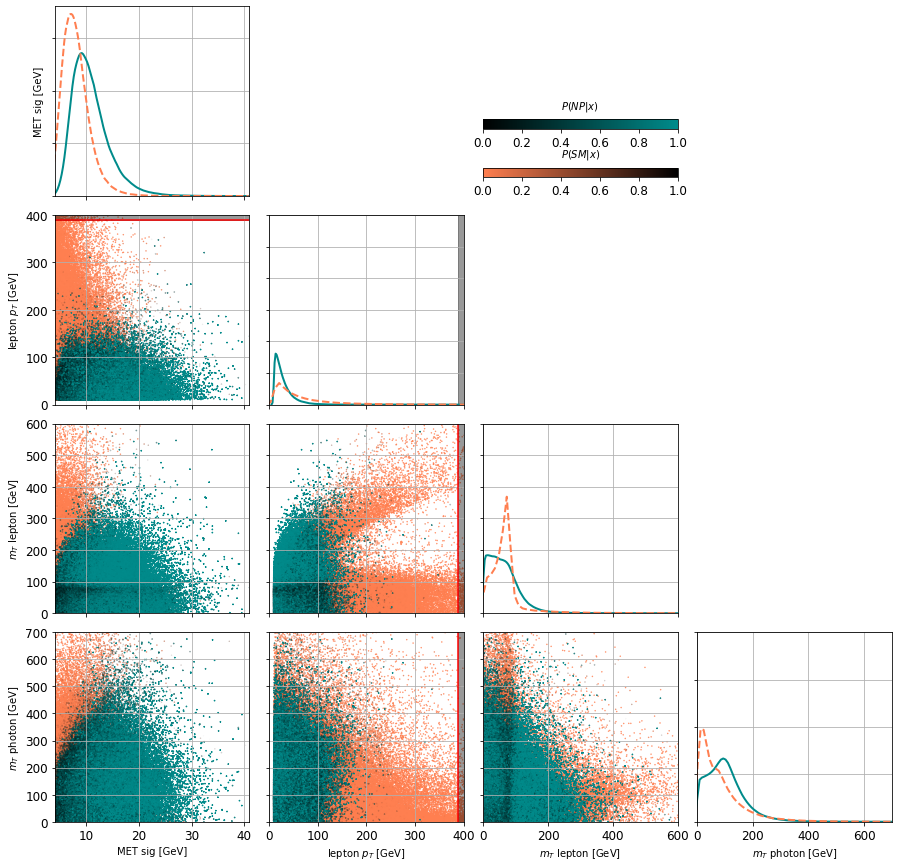

In [69]:
SM = df_test.loc[df_test['bkg_flag_pool'] > 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 0]

limites = [[4,41], [0,400], [0,600], [0,700]]
ylimites = [[0,0.18], [0,0.15], [0,0.03], [0,0.02]]

fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin = 0, vmax = 1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars[0])
ax[3,1].set_xlabel(imp_vars[1])
ax[3,2].set_xlabel(imp_vars[2])
ax[3,3].set_xlabel(imp_vars[3])

ax[0,0].set_ylabel(imp_vars[0])
ax[1,0].set_ylabel(imp_vars[1])
ax[2,0].set_ylabel(imp_vars[2])
ax[3,0].set_ylabel(imp_vars[3])

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist_OLD.pdf')

## BinnedLikelihood

In [70]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(439041,)
(324040,)


In [71]:
B_expected = int(B_expected)

In [155]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  224 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  224
range of our data:  [[0, 1]]


In [156]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP1:

[2.0082248257137674]


B_expected:  147986
S_expected:  202.45079649725346

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


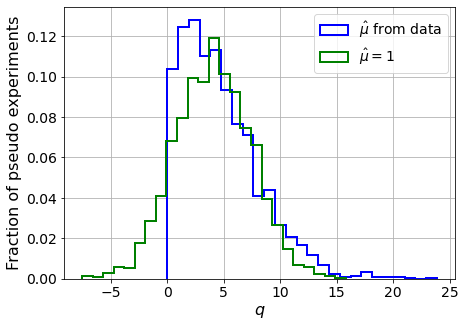

muhat mean:  1.028125
Z_bins:  2.0175272376703317
std Z_bins:  0.8628754231237187
Z_bins mu=0:  2.0189762198568157
std Z_bins mu=0:  0.831968896206629

--------


 FINAL RESULT:

[[2.0175272376703317, 0.8628754231237187, 1.028125, 2.0189762198568157, 0.831968896206629]]


In [157]:
# requested number of pseudo experiments
num_pseudo = 2000

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  147986
S_expected:  202.45079649725346

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


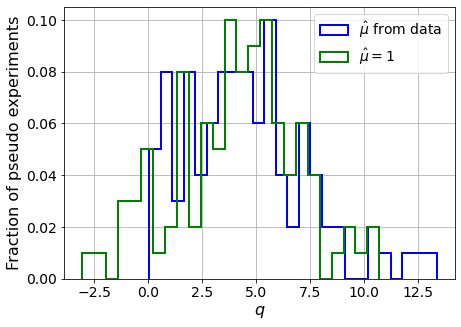

muhat mean:  1.0092043807903361
Z_bins:  2.0811436686027958
std Z_bins:  0.6888901505352494
Z_bins mu=0:  2.0796310719802613
std Z_bins mu=0:  0.6872851003165914

--------


 FINAL RESULT:

[[2.0811436686027958, 0.6888901505352494, 1.0092043807903361, 2.0796310719802613, 0.6872851003165914]]


In [158]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf  2151.66378942  2013.53428755  1843.62405184
  1643.69758171  1402.18250311  1107.36022748   744.87670133
   296.77911631  -281.88868635 -1017.15099543 -2092.48214707]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  1801.25202889


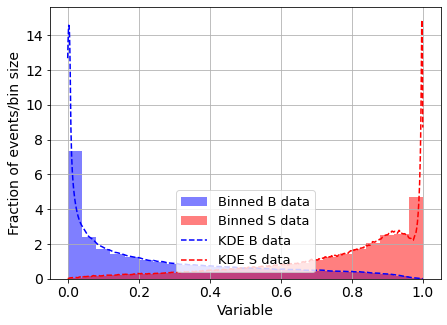

KDE Kernel:  epanechnikov
Background bandwidth:  0.008287452507534925
Signal bandwidth:  0.0031053121543406503


In [53]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

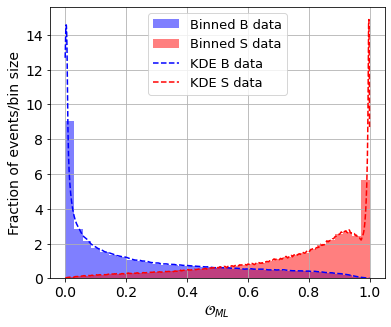

In [70]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,1000)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned B data');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned S data');

plt.plot(s_vals, dens_bkg, color='blue',label=r'KDE B data',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='red',label=r'KDE S data',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("$\mathcal{O}_{ML}$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_BP' + str(bp+1) + '.pdf')

In [54]:
print(norm_factor_SM)
print(norm_factor_NP)

97.97245046006259
271.8735532200964


In [55]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [56]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([143422., 138086.,   6451.,   4478.,   3429.,   2722.,   3403.,
          4645.,   5681.,  11725.]),
 array([7.08305385e-03, 1.52018219e+00, 3.03328133e+00, 4.54638047e+00,
        6.05947960e+00, 7.57257874e+00, 9.08567788e+00, 1.05987770e+01,
        1.21118762e+01, 1.36249753e+01, 1.51380744e+01]),
 [<matplotlib.patches.Polygon at 0x7f0a856c35e0>])

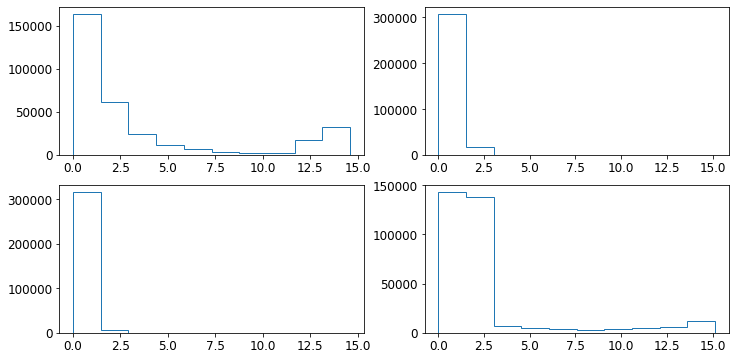

In [57]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [ ]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [ ]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_KDEfijo.pdf')

## Loop varying KDE

In [ ]:
B_expected

In [ ]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable_B_2.pdf')

## loop varying ML

In [52]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

In [53]:
#B_expected = 200_000 #ttgamma_expected + Wjets_expected + Wgamma_expected #+ \
             #ttjets_expected + zjets_expected #+ \
             #tj_expected + tb_expected + tw_expected
            #+ wz_expected + zz_expected + ww_expected + \


In [54]:
B_expected

26060.19515649158

0
AUC:0.9792919511930167
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


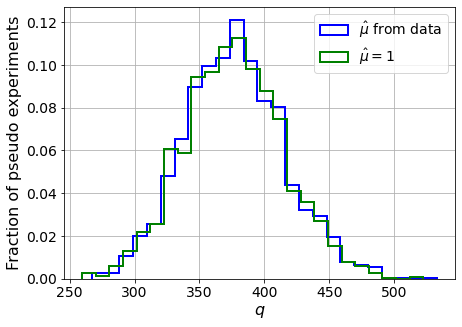

Z BL:(19.393890054557144, 0.9923314064144159, 1.025425, 19.40014410094604, 0.9895141046883912) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 29809.30928074 28412.94507773 26845.03208161
 25107.26595291 23195.65761936 21115.70511774 18867.19750372
 16456.29907797 13856.21347428 11073.45232546  8114.07385959
  4983.59674877  1677.1369114  -1731.95054125 -4987.68381826]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 15333.26282749 15292.6945439
 

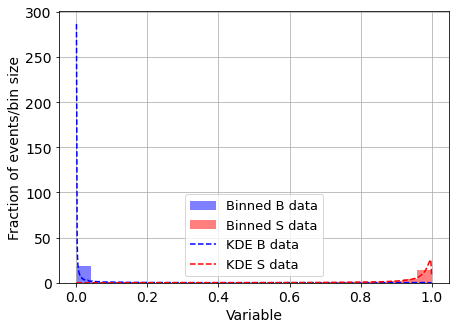

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
0.02040729142899847
0.02040729142899847
3 done
4 done
0.011146720881738579
0.011146720881738579
B_expected:  26060
S_expected:  636



100%|████████████████████████████████████████████████████████████████| 2000/2000 [12:37<00:00,  2.64it/s]


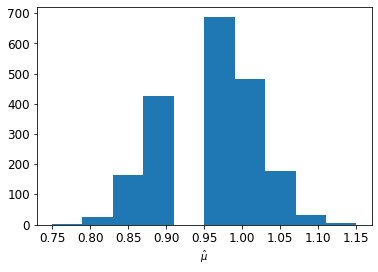

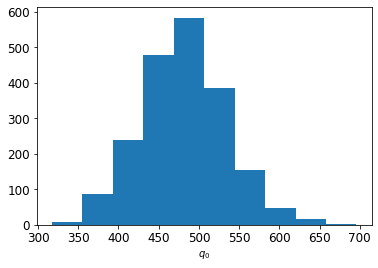

Z:21.88940848756374
Z_std:1.2011643545435688
Z_1:21.857174295708255
Z_std_1:1.2555295322493074
<B> = 26059.246+/-159.6646031028794
<S> = 635.3805+/-25.336687229193952
1
AUC:0.979463752606854
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

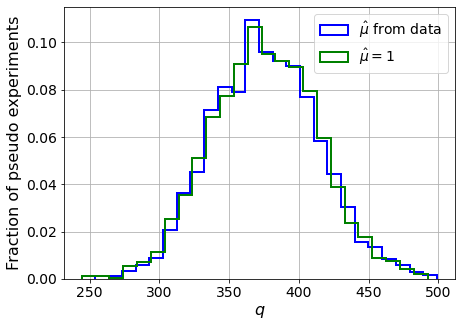

Z BL:(19.380148075229137, 0.9833026180250614, 1.02335, 19.386978050456367, 0.9840147353661057) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 31132.27188177 29934.99657618 28551.22877043 26998.61509787
 25281.18304816 23379.20672314 21296.7705183  19040.83548966
 16602.58927142 14000.89829044 11213.82112372  8228.3684093
  5049.28552337  1731.08739682 -1706.80697081 -4977.60947295]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 15590.05033301 15548.63462525
 

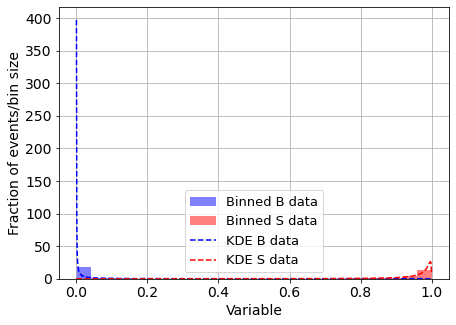

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
0.03495713027010931
0.03495713027010931
3 done
4 done
0.018304347694097774
0.018304347694097774
B_expected:  26060
S_expected:  636



100%|████████████████████████████████████████████████████████████████| 2000/2000 [13:11<00:00,  2.53it/s]


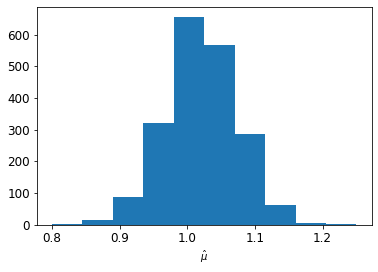

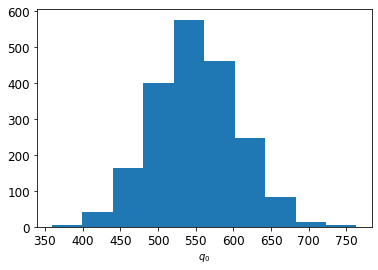

Z:23.429023740310395
Z_std:1.1862159470787048
Z_1:23.430590291287857
Z_std_1:1.1897492954834124
<B> = 26062.099+/-163.02142558265157
<S> = 635.5285+/-24.40305693453179
2
AUC:0.9796983087773363
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

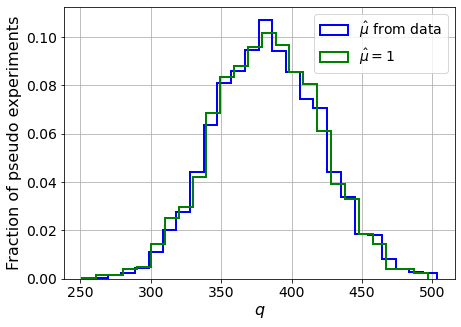

Z BL:(19.55232517617093, 0.966735365404615, 1.02455, 19.560428326905967, 0.9665405614125886) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 30293.44617827 28855.19346849 27256.86667282
 25483.39218295 23541.71039511 21427.71368853 19135.79211682
 16691.50001163 14075.71502887 11254.50948276  8249.91705426
  5077.88115432  1761.00460721 -1686.1712188  -4971.95233765]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 15767.35163767 15716.06820264


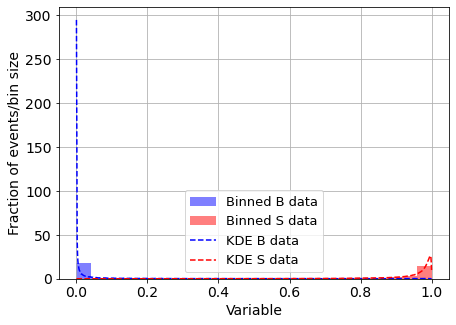

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
0.03955149588888894
0.03955149588888894
3 done
4 done
0.011224256550604016
0.011224256550604016
B_expected:  26060
S_expected:  636



100%|████████████████████████████████████████████████████████████████| 2000/2000 [14:46<00:00,  2.26it/s]


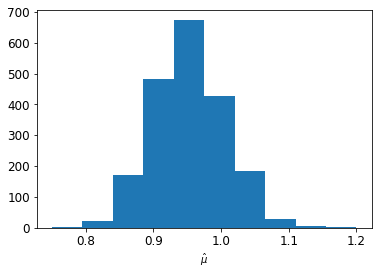

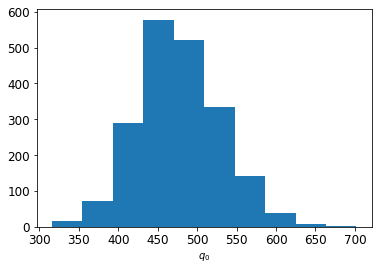

Z:21.760195800773218
Z_std:1.2068469974598355
Z_1:21.72850796580532
Z_std_1:1.262237778689427
<B> = 26064.153+/-161.6334327761432
<S> = 635.746+/-25.006708779845457
3
AUC:0.9796197772786774
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

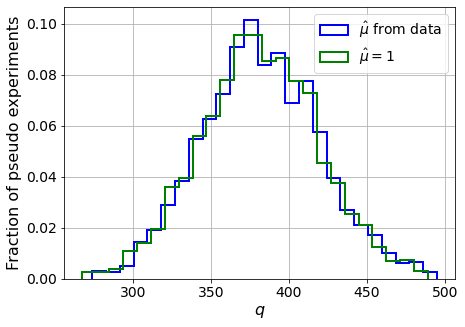

Z BL:(19.503738062805173, 0.9723428052038892, 1.026375, 19.51152977800159, 0.9706496681100426) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 31295.306618   30038.16253165 28609.24958342 27026.38057529
 25281.56145314 23369.74389734 21291.52737429 19041.19057455
 16609.27811383 14017.13918291 11231.32730806  8235.29883324
  5067.29747377  1732.94497947 -1711.687058   -4980.33866287]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 15505.61849828 15465.61935314


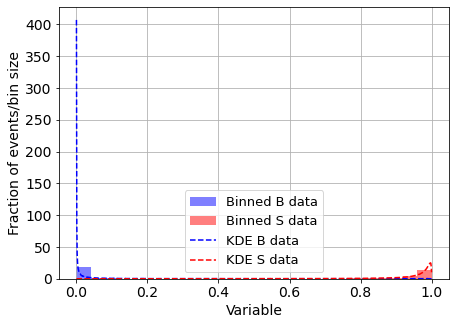

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
0.0368671865001844
0.0368671865001844
3 done
4 done
0.006714555492226438
0.006714555492226438
B_expected:  26060
S_expected:  636



100%|████████████████████████████████████████████████████████████████| 2000/2000 [17:18<00:00,  1.93it/s]


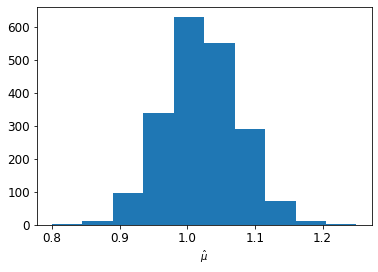

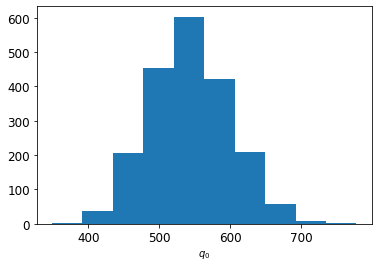

Z:23.280822610533438
Z_std:1.2103860753450728
Z_1:23.282183455992367
Z_std_1:1.2117053042454027
<B> = 26060.459+/-158.21687747835247
<S> = 636.0655+/-25.165218253573723
4
AUC:0.9794429354432763
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

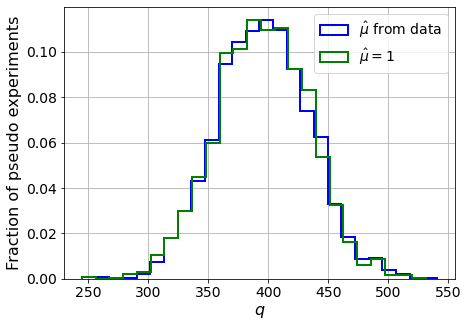

Z BL:(19.870665585225534, 0.9690507667154373, 1.027375, 19.87947647442385, 0.9679271293104006) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 30189.39666252 28749.25557136 27135.16234119
 25358.85294739 23401.09528371 21279.16232173 18981.43350065
 16538.49581596 13935.20520199 11152.94878801  8172.22988645
  5018.16257378  1723.08067249 -1699.58425037 -4970.27476966]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 15155.2955401  15144.49936764 15097.46818068


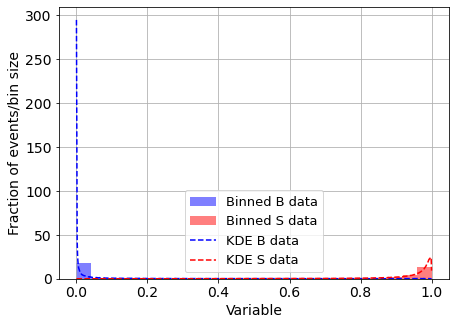

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
0.04915559597142102
0.04915559597142102
3 done
4 done
0.029332936296731914
0.029332936296731914
B_expected:  26060
S_expected:  636



100%|████████████████████████████████████████████████████████████████| 2000/2000 [12:31<00:00,  2.66it/s]


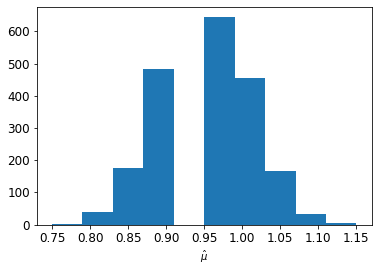

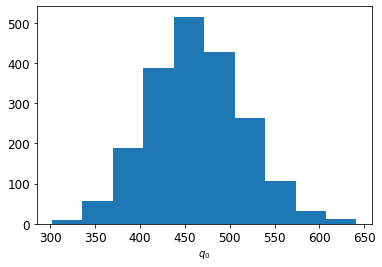

Z:21.50185248853521
Z_std:1.2220831410450161
Z_1:21.467589446778298
Z_std_1:1.2826708993393283
<B> = 26055.3905+/-163.50353210175615
<S> = 636.1595+/-25.255297657125325
5
AUC:0.9789873186255799
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

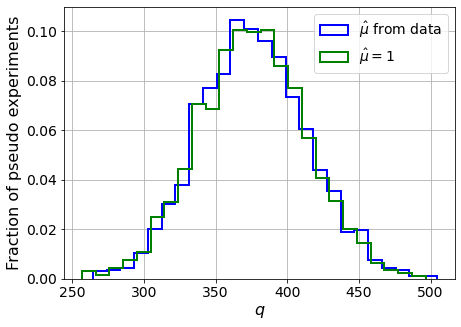

Z BL:(19.382476186073983, 0.9705672629345162, 1.026375, 19.392975162914137, 0.9693980929592566) with 15 bins


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 30901.02547115 29710.77212528 28342.125405   26806.46393576
 25086.76197988 23196.5267365  21103.81858126 18847.10581287
 16427.50104325 13826.23302345 11045.79716744  8098.91917329
  4958.85701865  1669.57292003 -1728.61591195 -4984.81354182]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf 15253.43823723 15204.56439381


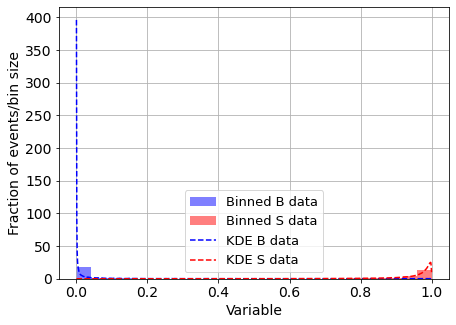

KDE Kernel:  epanechnikov
Background bandwidth:  0.0007122485584859914
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
0.02647912599736858
0.02647912599736858
3 done
4 done
0.0264574429058463
0.0264574429058463
B_expected:  26060
S_expected:  636



100%|████████████████████████████████████████████████████████████████| 2000/2000 [16:11<00:00,  2.06it/s]


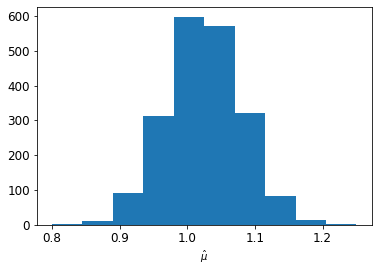

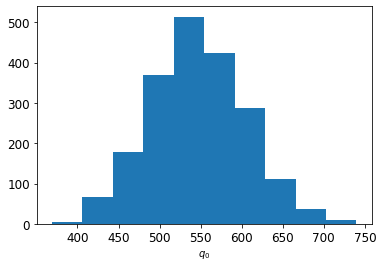

Z:23.301579183575424
Z_std:1.237152212220733
Z_1:23.30297338656086
Z_std_1:1.2362977012231489
<B> = 26062.267+/-163.11092762595646
<S> = 636.658+/-25.24353453857047
6
AUC:0.9788918034245812
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

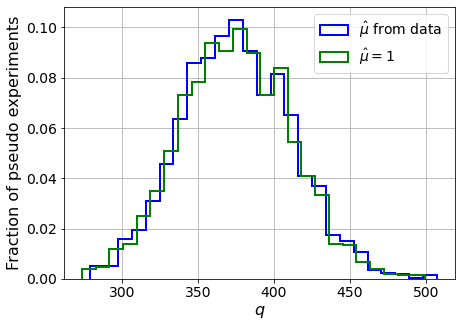

Z BL:(19.353898323658562, 0.9367346667764617, 1.02345, 19.353898323658562, 0.9360434443418213) with 15 bins


KeyboardInterrupt: 

In [55]:
MLL = True

Z_BL         = []
bin_nums     = []
bins_to_test = range(1,500) # number of bins we are testing to see if condition holds

Z_MLL_code   = []
Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []

num_bkg = []
num_sig = []

num_pseudo = 2000
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)
D_or_E = 'discovery'
for iloop in range(10):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))

    # FIND THE NUMBER OF BINS:
    num_bins = 15#max_num_bins(pred_XG_SM, int(B_expected), range_dat, 5, bins_to_test)
    Z_BL.append( BL_test_fast('discovery', pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, num_bins, range_dat, 5, linear_bins=True) )

    bin_nums.append(num_bins)
    print('Z BL:' + str(Z_BL[iloop]) + ' with ' + str(num_bins) + ' bins')

    if MLL:
        kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                                50000, # Numero de datos para fitear
                                                                                                np.logspace(-4.0, 0.05, 20), 
                                                                                                set_kernel='epanechnikov')
        print('This may take a while...')
    
        pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
        print('1 done')
        pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
        print('2 done')
    
        # Normalize
        pB_B_data = pB_B_data / norm_factor_SM
        pS_B_data = pS_B_data / norm_factor_NP
        
        print(np.min(pB_B_data))
        pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
        pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
        print(np.min(pB_B_data))
        
        pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
        print('3 done')
        pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
        print('4 done')
    
        # Normalize
        pB_S_data = pB_S_data / norm_factor_SM
        pS_S_data = pS_S_data / norm_factor_NP
        
        print(np.min(pB_S_data))
        pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
        pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
        print(np.min(pB_S_data))
        
        print('B_expected: ', int(B_expected))
        print('S_expected: ', int(S_expected[bp]))
        print('')
    
        #Z_MLL_code.append( MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, 
        #                      pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = num_pseudo) )
        #print('Z_MLL: ', Z_MLL_code[iloop][0])
        #print('std Z_MLL: ', Z_MLL_code[iloop][1])
        
        # indeces (to later build a random pseudo experiment)
        indices_B = [i for i in range(len(pS_B_data))]
        indices_S = [i for i in range(len(pS_S_data))]
        # loop over the number of pseudo experiments
        #np.random.seed(91218)
    
        muhat_selected_MLL_list = []
        q_muhat_MLL = []
        q_muhat_MLL_mu = []
        
        num_bkg_aux = []
        num_sig_aux = []
        for its in tqdm(range(num_pseudo)):
    
            # this pseudo-exp has B_rand number of B events
            B_rand = np.random.poisson(int(B_expected))
            num_bkg_aux.append(B_rand)
            
            ran_ind = np.random.choice(indices_B, B_rand)
    
            pB_B_data_shuf = []
            pS_B_data_shuf = []
    
            # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
            for i in ran_ind:
                pB_B_data_shuf.append(pB_B_data[i])
                pS_B_data_shuf.append(pS_B_data[i])
    
            pB_B_data_shuf  = np.array(pB_B_data_shuf)
            pS_B_data_shuf  = np.array(pS_B_data_shuf)
    
    
    
            # this pseudo-exp has S_rand number of S events
            S_rand = np.random.poisson(int(S_expected[bp]))
            num_sig_aux.append(S_rand)
    
            ran_ind = np.random.choice(indices_S, S_rand)
    
            pB_S_data_shuf = []
            pS_S_data_shuf = []
    
            # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
            for i in ran_ind:
                pB_S_data_shuf.append(pB_S_data[i])
                pS_S_data_shuf.append(pS_S_data[i])
    
            pB_S_data_shuf  = np.array(pB_S_data_shuf)
            pS_S_data_shuf  = np.array(pS_S_data_shuf)
    
            # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
            prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])
    
            # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
            prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])
    
    
    
            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment
    
            # approximation: mu_hat=1 (discovery)
            q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
    
    
            # ESTIMATE mu_hat for this particular ensemble (implicit equation)
            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
    
            # reference points
            sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
    
            # we need (implicit eq. for mu_hat) = 1
            # conditions considering the reference points
            if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
                print('muhat = 2.1')
                muhat_selected_MLL = 2.1
    
                print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))
    
            elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
                print('muhat = -0.1')
                muhat_selected_MLL = -0.1
    
                print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
                print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
                print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
                print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))
    
            elif sum_muhat_zero < 1 < sum_muhat_two:
                #print('muhat ~ 1')
    
                # grid, mu_hat is around 1
                muhat_test = np.arange(0, 2., 0.05)
    
                for vv in range(len(muhat_test)):
    
                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected_MLL = muhat_test[vv]
                        break
    
            elif sum_muhat_two < 1 < sum_muhat_zero:
                #print('muhat ~ 1')
    
                # grid, mu_hat is around 1
                muhat_test = np.arange(0, 2., 0.05)
    
                for vv in range(len(muhat_test)):
    
                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
    
                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected_MLL = muhat_test[vv]
                        break
    
    
            # save the computed mu_hat (within range) for each pseudo_experiment
            muhat_selected_MLL_list.append(muhat_selected_MLL)
    
    
            # compute the test statistic for each pseudo_exp considering mu_hat
            if muhat_selected_MLL > 0:
                q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
    
            else:
                q_muhat_MLL.append( 0 )
    
    
    
        # With the calculation of mu_hat
        muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
        Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
        Z_MLL.append( Z_MLL_aux )
        Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )
    
    
        # With the approximation of mu_hat
        Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
        Z_MLL_mu.append( Z_MLL_mu_aux )
        Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
        
        try:
            plt.hist(np.asarray(muhat_selected_MLL_list))
            plt.xlabel(r'$\hat{\mu}$')
            plt.savefig('../graph/BP' + str(bp+1) + '/muhat_hist_' + str(iloop) + '.pdf')
            plt.show()
            plt.clf()
    
            plt.hist(np.asarray(q_muhat_MLL))
            plt.xlabel(r'$q_{0}$')
            plt.savefig('../graph/BP' + str(bp+1) + '/q0_hist_' + str(iloop) + '.pdf')
            plt.show()
            plt.clf()
        except:
            pass
        print('Z:' + str(Z_MLL[iloop]))
        print('Z_std:' + str(Z_MLL_std[iloop]))
        print('Z_1:' + str(Z_MLL_mu[iloop]))
        print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))
        
        num_bkg.append(num_bkg_aux)
        num_sig.append(num_sig_aux)
        print('<B> = ' + str(np.mean(np.asarray(num_bkg_aux))) + '+/-' + str(np.std(np.asarray(num_bkg_aux))))
        print('<S> = ' + str(np.mean(np.asarray(num_sig_aux))) + '+/-' + str(np.std(np.asarray(num_sig_aux))))

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.text(0.5,0.08, 'Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(np.nan_to_num(Z_MLL_std, nan=0, posinf=0, neginf=0))),
         transform = plt.gca().transAxes)
plt.text(0.5,0.02, 'Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])), transform = plt.gca().transAxes)
plt.title('BP' + str(bp+1))
plt.xlabel('Iteration')
plt.savefig('../graph/loopBP' + str(bp+1) + '_50000_MLLvariable_ALLbkg_' + str(B_expected) + '_MET200.pdf')

In [ ]:
print('Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(np.nan_to_num(Z_MLL_std, nan=0, posinf=0, neginf=0))))
print('Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0]))  + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])) )

In [ ]:
Z_MLL

In [ ]:
Z_MLL_std

In [ ]:
print('AUC : ' + str(np.mean(np.asarray(auc_total))) + ' +/- ' + str(np.std(np.asarray(auc_total))))

In [ ]:
2